# PSF size in calexps and coadds for different filters (same region)

In [1]:
# general python packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt  
import matplotlib.patches as patches
from matplotlib.path import Path
from matplotlib.collections import PatchCollection
import itertools
import gc
from astropy.wcs import WCS
%matplotlib inline

# Rubin TAP service utilities
import lsst.geom as geom
import lsst.afw.display as afwDisplay  # for image visualization
import lsst.afw.table as afwTable
from lsst.daf.butler import Butler # access to LSST data products
import lsst.daf.base as dafBase
afwDisplay.setDefaultBackend('matplotlib')
from lsst.afw.geom.ellipses import Quadrupole, SeparableDistortionTraceRadius

from lsst.afw.cameraGeom import utils as cgUtils
from lsst.obs.lsst.cameraTransforms import LsstCameraTransforms, ampPixelToCcdPixel

from lsst.afw.cameraGeom import FIELD_ANGLE, FOCAL_PLANE, PIXELS
import lsst.afw.cameraGeom as cameraGeom
import lsst.afw.geom as afwGeom

import warnings
from astropy.units import UnitsWarning
warnings.simplefilter("ignore", category=UnitsWarning)
warnings.simplefilter("ignore", category=UserWarning)
warnings.simplefilter("ignore", category=FutureWarning)

In [2]:
repo = 'dp02'
collection = '2.2i/runs/DP0.2'
butler = Butler(repo, collections=collection)

In [3]:
def remove_figure(fig):
    """Remove a figure to reduce memory footprint. """
    # get the axes and clear their images
    for ax in fig.get_axes():
        for im in ax.get_images():
            im.remove()
    fig.clf()      # clear the figure
    plt.close(fig) # close the figure
    gc.collect()   # call the garbage collector

### Method to extract the image information:
- filter
- exposure time
- seeing
- air temperature
- ...

In [4]:
dataId = {'visit': 512055, 'detector': 76, 'band': 'g'}
ima = butler.get('calexp', dataId=dataId)

ima.getInfo()
ima.getFilter()
ima.getPhotoCalib()
ima.getInfo().getVisitInfo()
ima.getInfo().hasTransmissionCurve()
ima.getInfo().getFilterLabel().physicalLabel
ima.getInfo().getFilterLabel().bandLabel
ima.getInfo().getVisitInfo().getWeather().getAirPressure()
ima.getInfo().getVisitInfo().getWeather().getAirTemperature()
ima.getInfo().getVisitInfo().getWeather().getHumidity()
ima.getInfo().getVisitInfo().getWeather()
ima.getInfo().getVisitInfo().getExposureTime()

30.0

### Get a list of visits with good seeing

In [5]:
exp = butler.get('goodSeeingCoadd', tract=4849, patch=22, band='g')
coaddInputs = exp.getInfo().getCoaddInputs() 
#print(coaddInputs.ccds)
#print(coaddInputs.visits)

visits = butler.get('goodSeeingVisits', tract=4849, patch=22, band='g')
visits.keys()

dict_keys([193784, 193824, 254349, 254364, 399393, 419767, 449903, 449904, 449955, 680275, 680296, 697992, 703769, 719589, 921284, 921309, 1170053, 1206080, 1206127, 1225465, 1225497])

In [6]:
visits = butler.get('goodSeeingVisits', tract=4849, patch=22, band='i')
visits.keys()

dict_keys([196611, 204556, 204595, 204661, 211472, 227890, 227922, 261962, 269132, 269133, 421728, 458668, 458669, 478927, 478974, 478975, 641075, 665663, 665701, 665702, 670765, 678515, 678538, 682855, 731788, 766973, 766975, 906936, 906984, 919558, 919560, 945710, 951272, 1173729, 1185854, 1185856, 1185892, 1185894, 1205978, 1206032, 1229645, 1231914, 1231945, 1231985])

###  List all the visits in DP02 (any band) for a certain region 

In [17]:
my_ra_deg = 55.745834
my_dec_deg = -32.269167
delta_pos = 0.02 #0.008

ccdTableRef = list(butler.registry.queryDatasets('ccdVisitTable'))
ccdTable = butler.get(ccdTableRef[0])

posRA = (ccdTable['ra'] <= my_ra_deg + delta_pos ) & (ccdTable['ra'] >= my_ra_deg - delta_pos )
posDEC = (ccdTable['decl'] <= my_dec_deg + delta_pos ) & (ccdTable['decl'] >= my_dec_deg - delta_pos )

ccd_visit_list = ccdTable[posRA & posDEC][['visitId', 'detector']]

for f in [ccd_visit_list.loc[j] for j in [i for i in ccd_visit_list.index]]:
    visit = f['visitId']    
    detector = f['detector']
    dataId = {'visit': visit, 'detector': detector}#, 'band': f}
    ima = butler.get('calexp', dataId=dataId)
    band = ima.getInfo().getFilterLabel().bandLabel
    print(visit, detector, band)


1169217 69 g
953552 148 i
951283 107 i
713248 185 i
893799 69 i
227891 69 i
913856 116 r
908959 119 r
909008 31 r
1028707 163 r
1187391 43 u
760255 163 u
647576 152 y
1178912 129 y
1162434 45 y


### Select a single image per filter based on the coordinates -> the nearest to the given RA and DEC. 

In [18]:
my_ra_deg = 55.745834
my_dec_deg = -32.269167
delta_pos = 0.02 #0.008

ccdTableRef = list(butler.registry.queryDatasets('ccdVisitTable'))
ccdTable = butler.get(ccdTableRef[0])

posRA = (ccdTable['ra'] <= my_ra_deg + delta_pos ) & (ccdTable['ra'] >= my_ra_deg - delta_pos )
posDEC = (ccdTable['decl'] <= my_dec_deg + delta_pos ) & (ccdTable['decl'] >= my_dec_deg - delta_pos )

ccd_visit_list = ccdTable[posRA & posDEC]

nearest = []
for b in ['u', 'g', 'r', 'i']:
    r_dif = [] 
    for f in [[ccd_visit_list.loc[j],str(j)] for j in [i for i in ccd_visit_list.index]]:
        if f[0]['band'] == b:
            r = np.sqrt((f[0]['ra']- my_ra_deg)**2 + (f[0]['decl']- my_dec_deg)**2)
            r_dif.append([f[1], r])

    r_dif = np.asarray(r_dif)
    id_nearest = r_dif[r_dif[:, 1].argsort()]
    nearest.append(id_nearest[0][0])

In [19]:
nearest

['760255163', '1169217069', '908959119', '951283107']

### For each selected image (calexp) display luminosity and psf size distribution

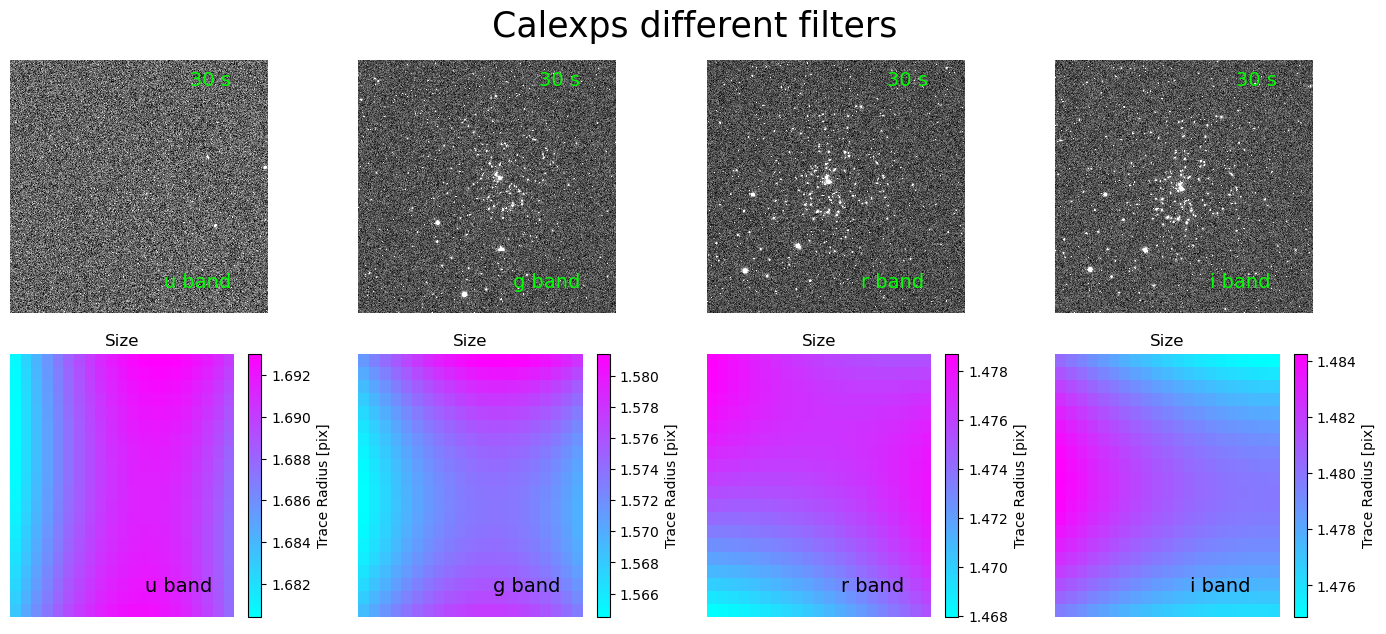

In [9]:
fig, ax = plt.subplots(2, 4, figsize=(14, 6))

i=0
for f in [ccd_visit_list.loc[j] for j in [int(ii) for ii in nearest]]: 
    
    visit = f['visitId']    
    detector = f['detector']
    dataId = {'visit': visit, 'detector': detector}#, 'band': f}
    ima = butler.get('calexp', dataId=dataId)
    band = ima.getInfo().getFilterLabel().bandLabel
    expTime = ima.getInfo().getVisitInfo().getExposureTime()
    #sourcesCat = butler.get('src', dataId)
    
    psf = ima.getPsf()
    shape = psf.computeShape()
    xMin, yMin = ima.getBBox().getMin()
    xMax, yMax = ima.getBBox().getMax()
    x_array = np.arange(xMin, xMax+1, 200)
    y_array = np.arange(yMin, yMax+1, 200)
    xx, yy = np.meshgrid(x_array, y_array)
    
    size = [] # trace radius
    det_radius = []
    i_xx, i_yy, i_xy = [] , [] , []
    for x, y in zip(xx.flatten(), yy.flatten()):
        point = geom.Point2D(x, y)
        shape = psf.computeShape(point)
        size.append(shape.getTraceRadius())

    size = np.reshape(size, xx.shape)

    plt.sca(ax[0,i])  
    display1 = afwDisplay.Display(frame=fig)
    display1.scale('linear', 'zscale')
    #display1.scale('asinh', -5, 20)
    display1.mtv(ima.image)
    display1.show_colorbar(False)
    ax[0,i].axis('off')
    plt.text(0.6, 0.1, band +" band", color = 'lime', fontsize=14, transform=ax[0,i].transAxes)
    plt.text(0.7, 0.9, str(int(expTime))+' s', color = 'lime', fontsize=14, transform=ax[0,i].transAxes)
    
    plt.sca(ax[1,i])  
    plt.pcolormesh(xx, yy, size, vmin=np.min(size), vmax=np.max(size), cmap='cool', shading='auto')
    colorbar = plt.colorbar(label='Trace Radius [pix]')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Size')
    plt.text(0.6, 0.1, band +" band", color = 'k', fontsize=14, transform=ax[1,i].transAxes)
    ax[1,i].axis('off')
    i=i+1
    
plt.tight_layout()
fig.suptitle('Calexps different filters', fontsize=25, y= 1.05)
plt.show()
remove_figure(fig)

*****************
## COADDS 
-For the same coordinates extract tract and patch. 

-Select the coadd for each filter. 

-For each coadded image display luminosity and psf size distribution.

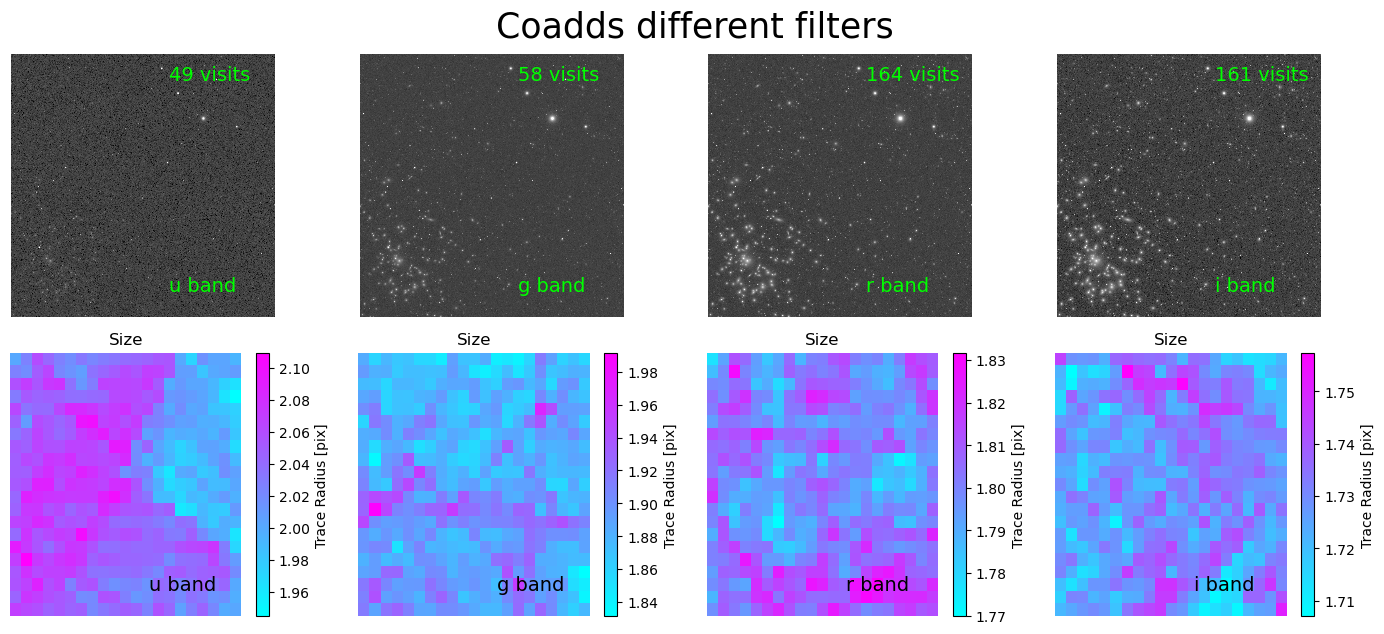

In [6]:
fig, ax = plt.subplots(2, 4, figsize=(14, 6))

i=0
for f in ['u', 'g', 'r', 'i']:
    #dataId = {'band': f, 'tract': 4851, 'patch': 29}
    dataId = {'band': f, 'tract': 4431, 'patch': 17}
    ima = butler.get('deepCoadd', dataId=dataId)
    
    coadd_inputs = butler.get("deepCoadd_calexp.coaddInputs", dataId)
    n_visits = len(coadd_inputs.visits)

    psf = ima.getPsf()
    shape = psf.computeShape()
    xMin, yMin = ima.getBBox().getMin()
    xMax, yMax = ima.getBBox().getMax()
    x_array = np.arange(xMin, xMax+1, 200)
    y_array = np.arange(yMin, yMax+1, 200)
    xx, yy = np.meshgrid(x_array, y_array)
    
    size = [] # trace radius
    det_radius = []
    i_xx, i_yy, i_xy = [] , [] , []
    for x, y in zip(xx.flatten(), yy.flatten()):
        point = geom.Point2D(x, y)
        shape = psf.computeShape(point)
        size.append(shape.getTraceRadius())

    size = np.reshape(size, xx.shape)

    plt.sca(ax[0,i])  
    display1 = afwDisplay.Display(frame=fig)
    display1.scale('asinh', -0.2, 0.3)
    display1.mtv(ima.image)
    display1.show_colorbar(False)
    ax[0,i].axis('off')
    plt.text(0.6, 0.1, f +" band", color = 'lime', fontsize=14, transform=ax[0,i].transAxes)
    plt.text(0.6, 0.9, str(n_visits) +" visits", color = 'lime', fontsize=14, transform=ax[0,i].transAxes)
    
    plt.sca(ax[1,i])  
    plt.pcolormesh(xx, yy, size, vmin=np.min(size), vmax=np.max(size), cmap='cool', shading='auto')
    colorbar = plt.colorbar(label='Trace Radius [pix]')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Size')
    plt.text(0.6, 0.1, f +" band", color = 'k', fontsize=14, transform=ax[1,i].transAxes)
    ax[1,i].axis('off')
    
    i=i+1

plt.tight_layout()
fig.suptitle('Coadds different filters', fontsize = 25, y = 1.05)
plt.show()
remove_figure(fig)

AttributeError: 'NoneType' object has no attribute 'add_subplot'

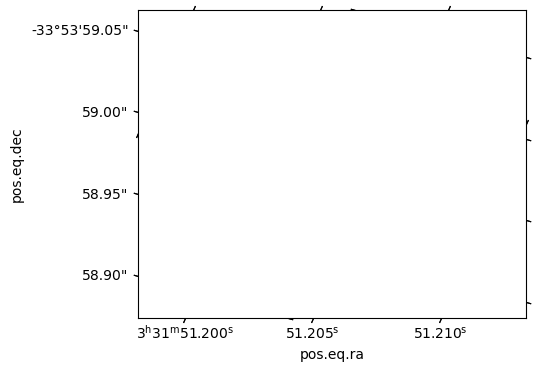

In [4]:
dataId = {'visit': 192350, 'detector': 175, 'band': 'i'}

# Retrieve the data using the `butler` instance and its function `get()`
ima = butler.get('calexp', **dataId)
cat = butler.get('src', **dataId)

psf = ima.getPsf()
psf_used = cat[cat['calib_psf_used'] == True]
output = [] 

for i in range(len(psf_used)):
    ra = psf_used[i]['coord_ra']
    dec = psf_used[i]['coord_dec']
    point = psf_used[i].getCentroid()
    shape_psf = psf.computeShape(point)
    radius_psf = shape_psf.getTraceRadius()
    output.append([ra, dec, radius_psf])

#ima.getWcs().pixelToSky(700,2000).getRa().asDegrees() 

band = ima.getInfo().getFilterLabel().bandLabel
output = np.asarray(output)
    
fig= plt.figure(figsize=(5,4))
ax = plt.gca()

# Set the figure's projection to be the WCS of the calexp
#plt.subplot(projection=WCS(calexp.getWcs().getFitsMetadata()))
plt.subplot(projection=WCS(ima.getWcs().getFitsMetadata()))

# Define the extent in pixel coordinates using the bounding box
#calexp_extent = (calexp.getBBox().beginX, calexp.getBBox().endX,
#                 calexp.getBBox().beginY, calexp.getBBox().endY)

calexp_extent = (ima.getBBox().beginX, ima.getBBox().endX,
                 ima.getBBox().beginY, ima.getBBox().endY) 
# Display the calexp image data array using the gray colormap (cmap)
#  and use approximately the same min and max scale values as above
ax.imshow(ima.image.array, cmap='gray', vmin=-200.0, vmax=400,
                extent=calexp_extent, origin='lower')

sc = ax.scatter(output[:,0], output[:,1], s=50, c=output[:,2], cmap='cool', edgecolor='face', facecolors ='none')
sc.set_edgecolors(sc.get_facecolors());
plt.colorbar(sc, ax = ax)
sc.set_facecolor('none')

plt.text(0.7, 0.9, band + " band", color = 'k', fontsize=13, transform=ax.transAxes)
    
plt.xlabel('Right Ascension')
plt.ylabel('Declination')


In [5]:
ima.getWcs().getFitsMetadata().getArray()

TypeError: PropertyList.getArray() missing 1 required positional argument: 'name'

In [16]:
calexp_extent

(0, 4072, 0, 4000)

## PSF size for full visit

# ['760255163', '1169217069', '908959119', '951283107'] any of these has the 189 detectors

In [39]:
def plot_FullVisit_RADEC_catalog(visit,n_ccds):
    fig= plt.figure(figsize=(5,4))
    ax = plt.gca()

    output = []
    for det in range(n_ccds):
        xdataId = {'visit':visit,'detector': det} 
        ima = butler.get('calexp', **xdataId)
        cat = butler.get('src', **xdataId)
    
        ################ PSF ################
        psf = ima.getPsf()
        psf_used = cat[cat['calib_psf_used'] == True]
    
        for i in range(len(psf_used)):
            ra = psf_used[i]['coord_ra']
            dec = psf_used[i]['coord_dec']
            point = psf_used[i].getCentroid()
            shape_psf = psf.computeShape(point)
            radius_psf = shape_psf.getTraceRadius()
            output.append([ra, dec, radius_psf])

    band = ima.getInfo().getFilterLabel().bandLabel
    output = np.asarray(output)
    sc = ax.scatter(output[:,0], output[:,1], c=output[:,2], s=1, cmap='cool')
    plt.colorbar(sc, ax = ax)
    plt.text(0.7, 0.9, band + " band", color = 'k', fontsize=13, transform=ax.transAxes)

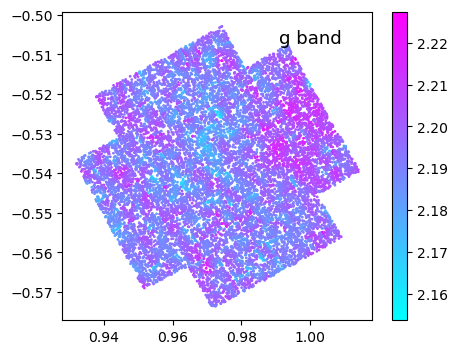

In [40]:
#['760255163', '1169217069', '908959119', '951283107']
plot_FullVisit_RADEC_catalog(400357,189)

## PSF diagnostics for coadds

In [11]:
#PSF_diagnostics(4431, 17, 'g')

def PSF_diagnostics(tract, patch, band): 
    dataId= {'band': band, 'tract': tract, 'patch': patch} 
    calexp = butler.get('deepCoadd', dataId=dataId) 
    src = butler.get('deepCoadd_forced_src', **dataId)

    psf = calexp.getPsf()
    shape = psf.computeShape()
    xMin, yMin = calexp.getBBox().getMin()
    xMax, yMax = calexp.getBBox().getMax()
    x_array = np.arange(xMin, xMax+1, 200)
    y_array = np.arange(yMin, yMax+1, 200)
    xx, yy = np.meshgrid(x_array, y_array)

    size = [] # trace radius
    det_radius = []
    i_xx, i_yy, i_xy = [] , [] , []
    for x, y in zip(xx.flatten(), yy.flatten()):
        point = geom.Point2D(x, y)
        shape = psf.computeShape(point)
        size.append(shape.getTraceRadius())
        det_radius.append(shape.getDeterminantRadius()) 
        i_xx.append(shape.getIxx())
        i_yy.append(shape.getIyy())
        i_xy.append(shape.getIxy())
    size = np.reshape(size, xx.shape)
    i_xx = np.reshape(i_xx, xx.shape)
    i_yy = np.reshape(i_yy, xx.shape)
    i_xy = np.reshape(i_xy, xx.shape)
    det_radius = np.reshape(det_radius, xx.shape)
    dif_rad = np.abs(size - det_radius)

    e1 = (i_xx - i_yy) / (i_xx + i_yy)
    e2 = (2. * i_xy) / (i_xx + i_yy)
    e = np.sqrt(e1**2 + e2**2)
    theta = np.arctan2(2. * i_xy, i_xx - i_yy) / 2.
    ex = e * np.cos(theta)
    ey = e * np.sin(theta)

    def ellipticity_radii(i_xx, i_yy, i_xy):
        theta = np.arctan2(2. * i_xy, i_xx - i_yy) / 2.
        e1 = (i_xx - i_yy) / (i_xx + i_yy)
        e2 = (2. * i_xy) / (i_xx + i_yy)
        e = np.sqrt(e1**2 + e2**2)
        TraceRad = np.sqrt((i_xx + i_yy) / 2.)
        DetRad = (i_xx * i_yy - i_xy**2)**(1. / 4.)
        return TraceRad, e, e1, e2

    def comparison_src_psf(sample):
        output0 = []
        for i in range(len(sample)):
            point = sample[i].getCentroid()
            shape_psf = psf.computeShape(point)
            i_xx_psf = sample[i]['base_SdssShape_psf_xx']#shape_psf.getIxx()
            i_yy_psf = sample[i]['base_SdssShape_psf_yy']#shape_psf.getIyy()
            i_xy_psf = sample[i]['base_SdssShape_psf_xy']#shape_psf.getIxy()
            TraceRad_psf, e_psf, e1_psf, e2_psf = ellipticity_radii(i_xx_psf, i_yy_psf, i_xy_psf)

            i_xx_star = sample[i]['base_SdssShape_xx']
            i_yy_star = sample[i]['base_SdssShape_yy']
            i_xy_star = sample[i]['base_SdssShape_xy']
            e_src = ellipticity_radii(i_xx_star, i_yy_star, i_xy_star)[1]
            TraceRad_star, e_star, e1_star, e2_star = ellipticity_radii(i_xx_star, i_yy_star, i_xy_star)
            x_point = point[0]
            y_point = point[1]
            mag = -2.5*np.log10(sample[i]['base_CircularApertureFlux_17_0_instFlux'])
    
            output0.append([TraceRad_psf, e_psf, e1_psf, e2_psf, TraceRad_star, e_star, e1_star, e2_star, mag, x_point, y_point])

        return np.asarray(output0)

    psf_used = src[src['base_ClassificationExtendedness_value']== 0.][0:4000]
    psf_reserved = src[src['base_ClassificationExtendedness_value']== 0.][0:4000]
    output = comparison_src_psf(psf_used)

    df = pd.DataFrame({'TraceRad_psf': output[:,0], 'e_psf': output[:,1], 'e1_psf': output[:,2], 'e2_psf': output[:,3], 'TraceRad_star': output[:,4], 'e_star': output[:,5], 'e1_star': output[:,6], 'e2_star': output[:,7], 'mag': output[:,8], 'x': output[:,9], 'y': output[:,10] })
    df = df[df['TraceRad_star']<=3]
    df['delta_size'] = df.TraceRad_psf - df.TraceRad_star #TraceRad_psf - TraceRad_star
    df['delta_e1'] = df.e1_psf - df.e1_star # e1_psf - e1_star
    df['delta_e2'] = df.e1_psf - df.e1_star #e2_psf - e2_star

    fig, ax = plt.subplots(2, 2, figsize=(12, 10))

    #############  CALEXP  #############
    plt.sca(ax[0,0])  
    display1 = afwDisplay.Display(frame=fig)
    display1.scale('linear', 'zscale')
    display1.mtv(calexp.image)
    display1.show_colorbar(False)
    plt.text(0.6, 0.1, band +" band", color = 'lime', fontsize=20, transform=ax[0,0].transAxes)
    plt.text(0.1, 0.9, "tract "+ str(tract) + "   patch " + str(patch), color = 'orange', fontsize=16, transform=ax[0,0].transAxes)

    #############  TRACE RADIUS  #############
    plt.sca(ax[0,1])
    plt.pcolormesh(xx, yy, size, vmin=np.min(size), vmax=np.max(size), cmap='cool', shading='auto')
    colorbar = plt.colorbar(label='Trace Radius [pix]')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Size')

    #############  ELLIP STICKS  #############
    plt.sca(ax[1,0])
    plt.quiver(xx, yy, ex, ey, e, headlength=0., headwidth=1., pivot='mid', width=0.01, cmap='plasma')
    colorbar = plt.colorbar(label='e')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Ellipticity Sticks')
    
    ############# ELLIPTICITY  #############
    plt.sca(ax[1,1])
    plt.pcolormesh(xx, yy, e, vmin=np.min(e), vmax=np.max(e), cmap='plasma', shading='auto')
    colorbar = plt.colorbar(label='e')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Ellipticity');
    plt.show()
       
    ########################################################
    ####################  SCATTER PLOTS ####################
    ########################################################
    bins = np.linspace(df.mag.min(),df.mag.max(), 30)
    
    data_cut = pd.cut(df.mag,bins)           
    grp = df.groupby(by = data_cut)        
    ret = grp.aggregate(np.mean) 
    grp_mead = grp.aggregate(np.median)

    fig, ax = plt.subplots(3, 1, figsize=(8, 8))

    plt.sca(ax[0]) 
    plt.axhline(y=0, color='k', ls='--', lw=1.5, alpha=0.7)
    plt.scatter(df.mag, df.delta_size, marker='.', color = 'b', alpha=0.2)
    plt.plot(ret.mag, ret.delta_size,'r',lw=1,alpha=.7)
    plt.plot(grp_mead.mag, grp_mead.delta_size,'lime',lw=1,alpha=.7)
    plt.ylabel(r'$\Delta_{size}$',  fontsize=20)
    plt.xlim(-6,3)
    plt.yticks(fontsize = 14)
    
    plt.sca(ax[1])
    plt.axhline(y=0, color='k', ls='--', lw=1.5, alpha=0.7)
    plt.scatter(df.mag, df.delta_e1, marker='.', color = 'b', alpha=0.2)
    plt.plot(ret.mag, ret.delta_e1,'r',lw=1,alpha=.7)
    plt.ylabel(r'$\Delta_{e1}$',  fontsize=20)
    plt.ylim(-0.1, 0.1)
    plt.xlim(-6, 3)
    plt.xticks(fontsize = 14)
    plt.yticks(fontsize = 14) 
    
    plt.sca(ax[2])  
    plt.axhline(y=0, color='k', ls='--', lw=1.5, alpha=0.7)
    plt.scatter(df.mag, df.delta_e2, marker='.', color = 'b', alpha=0.2)
    plt.plot(ret.mag, ret.delta_e2,'r',lw=1,alpha=.7)
    plt.ylabel(r'$\Delta_{e2}$',  fontsize=20)
    plt.xlabel('magnitude', fontsize=18)
    #plt.ylim(-0.08, 0.08)
    plt.xlim(-6, 3)
    plt.xticks(fontsize = 14)
    plt.yticks(fontsize = 14) 
    plt.subplots_adjust(hspace=0.0)

    

/tmp/ipykernel_9453/1987325079.py:75: RuntimeWarning: invalid value encountered in log10
  mag = -2.5*np.log10(sample[i]['base_CircularApertureFlux_17_0_instFlux'])


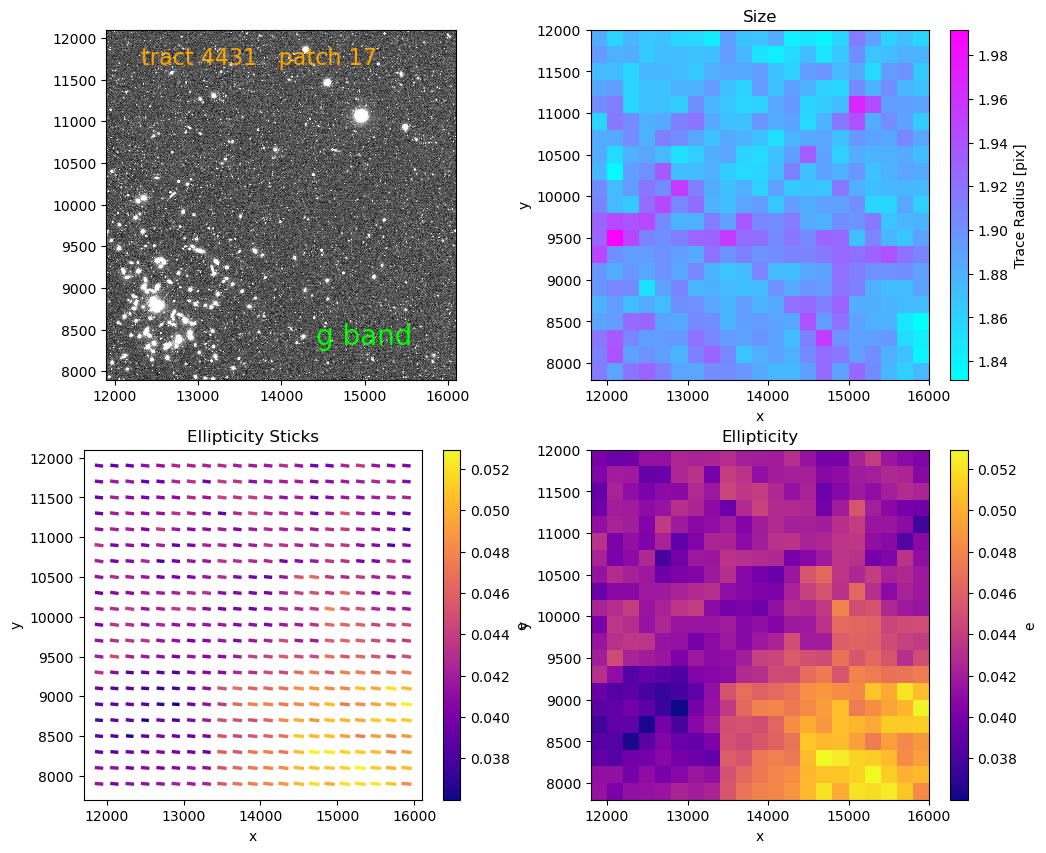

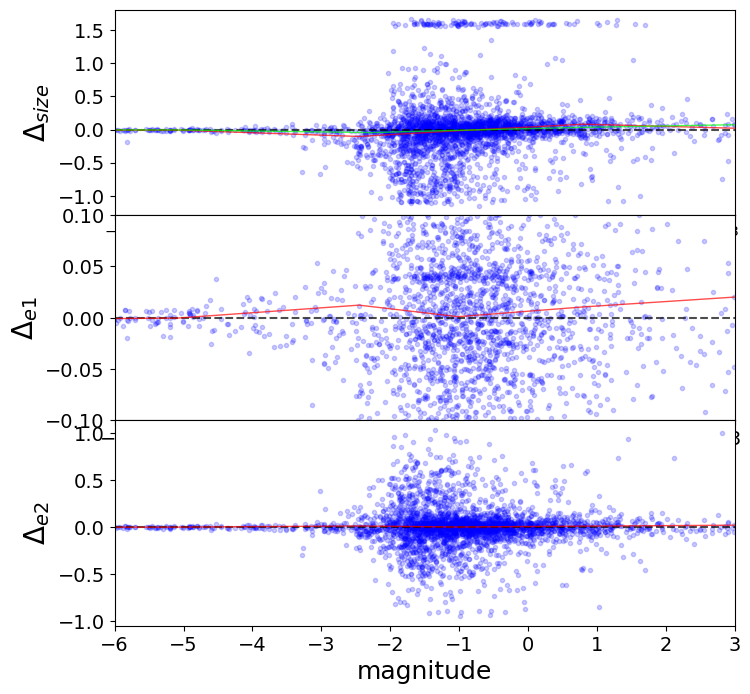

In [15]:
PSF_diagnostics(4431, 17, 'g')

In [ ]:
#PSF_diagnostics(4431, 17, 'g')
dataId= {'band': 'g', 'tract': 4431, 'patch': 17}# {'band':band,'visit':visit,'detector':detector}  
calexp = butler.get('deepCoadd', dataId=dataId) # butler.get('calexp', **dataId)
src = butler.get('deepCoadd_forced_src', **dataId)

src['base_CircularApertureFlux_17_0_instFlux']

In [ ]:
srcCoadd = butler.get('deepCoadd_forced_src', dataId)
srcCoadd = srcCoadd.copy(True)
srcCoadd.asAstropy()[0:3]

schema_coadd_src = butler.get('deepCoadd_forced_src_schema')
schema_coadd_src.asAstropy()
# Define an array that is all of the column names
all_names = schema_coadd_src.schema.getOrderedNames()

select_columns = []
# Loop over the names and look for the term 'psf'
for i, name in enumerate(all_names):
    if name.find('Extend') >= 0:
        print(i, name)
        select_columns.append(name)
del all_names

In [ ]:
len(srcCoadd['base_ClassificationExtendedness_value'][srcCoadd['base_ClassificationExtendedness_value']== 0.])

In [ ]:
PSF_diagnostics(400357, 43, 'u')